In [1]:
import os 

import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nbimporter
import Useful_Visualization_Functions
from pyspark.ml import *
from pyspark.sql import *
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import Imputer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import col, explode, array, lit

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

warnings.filterwarnings("ignore")
import pyspark.sql.functions as F

### Build spark session

In [2]:
myspark = SparkSession\
    .builder\
    .appName("AWS-Spark")\
    .config("spark.driver.memory", "200g") \
    .config("spark.sql.shuffle.partitions",6)\
    .config("spark.sql.repl.eagereval.enabled",True)\
    .getOrCreate()

22/05/24 19:28:53 WARN Utils: Your hostname, nuno-g14 resolves to a loopback address: 127.0.1.1; using 10.15.55.168 instead (on interface wlp2s0)
22/05/24 19:28:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/24 19:29:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Import parquet files

In [3]:
df_clean = myspark.read.parquet("clean-noaa")
# noaa_data.show(10)

### Undersampling

In [4]:
zero_df = df_clean.filter(col("ItRained") == 0)
one_df = df_clean.filter(col("ItRained") == 1)

major_df, minor_df = (zero_df, one_df) if zero_df.count() > one_df.count() else (one_df, zero_df)

#if zero_df.count() > one_df.count():
#    major_df = zero_df
#    minor_df = one_df
#else:
#    major_df = one_df
#    minor_df = zero_df
    
ratio = major_df.count()/minor_df.count()
sampled_majority_df = major_df.sample(False, 1/ratio)
df_clean = sampled_majority_df.unionAll(minor_df)
df_clean.select("ItRained").summary().show()

+-------+------------------+
|summary|          ItRained|
+-------+------------------+
|  count|            301852|
|   mean|0.5002153373176259|
| stddev|0.5000007818522709|
|    min|                 0|
|    25%|                 0|
|    50%|                 1|
|    75%|                 1|
|    max|                 1|
+-------+------------------+



In [5]:
cols_interest = ['TEMP','DEWP','SLP','VISIB','WDSP','MXSPD','MAX','MIN']
non_labeled_df = df_clean.select(cols_interest)
labels_col = df_clean.select('TEMP','DEWP','SLP','VISIB','WDSP','MXSPD','MAX','MIN','ItRained')

In [6]:
assembler = VectorAssembler(inputCols=cols_interest,outputCol="features")
non_labeled_df = assembler.transform(non_labeled_df)
# Trains a k-means model.
kmeans = KMeans(featuresCol="features").setK(2).setSeed(1)
model = kmeans.fit(non_labeled_df)

# Make predictions
predictions = model.transform(non_labeled_df)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.6368418774614746
Cluster Centers: 
[  34.06796978   29.04244606 1010.74529505   10.76902825    7.12589046
   11.45882485   39.69517851   27.82066144]
[ 9.91509496e+00  3.37971315e+00  1.02002684e+03  1.41067559e+01
  6.13126305e+00  9.62018642e+00  1.83602749e+01 -3.92705853e-01]


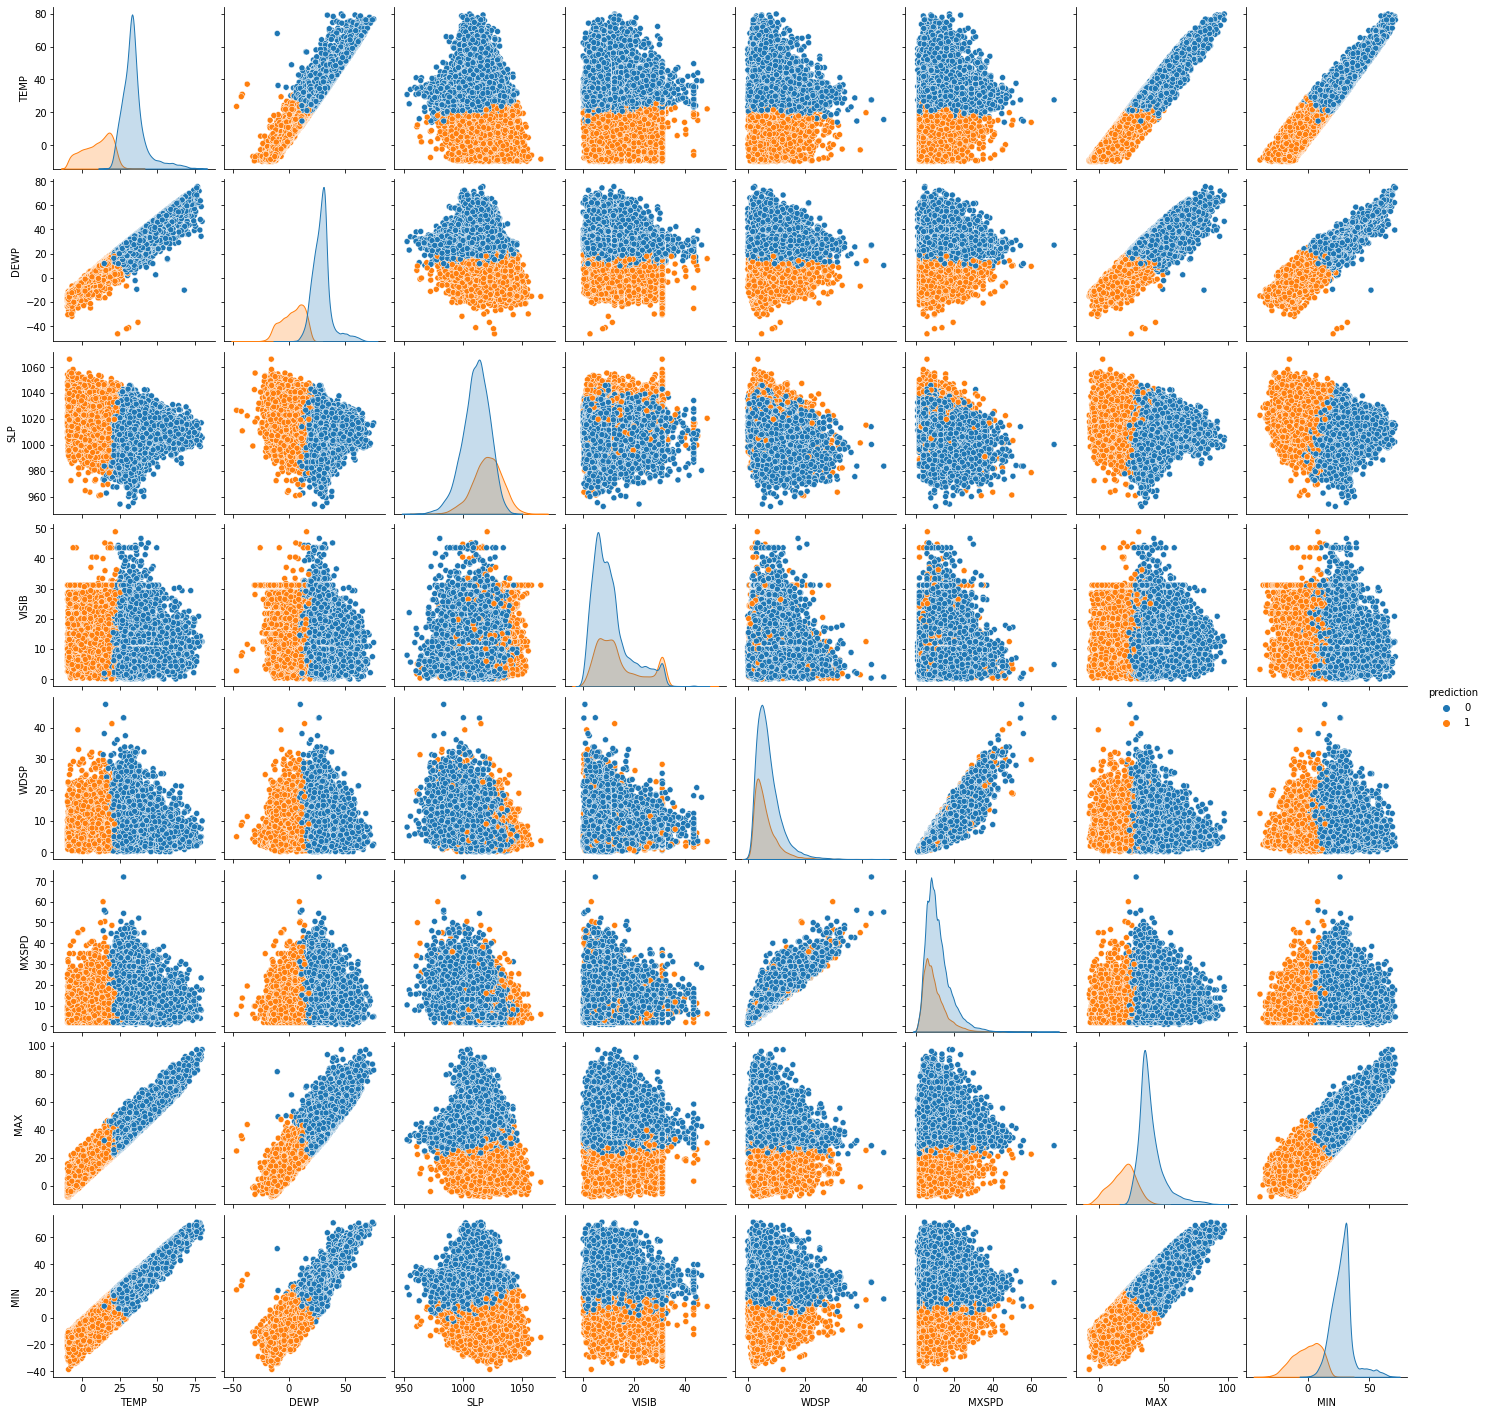

In [7]:
# predictions.orderBy('prediction', ascending=True).show()
predictions_df_sampled = predictions.sample(False, 0.1).toPandas()
Useful_Visualization_Functions.plotScatterMatrix(predictions_df_sampled, "prediction")